In [1]:
import os
import pandas as pd
import numpy as np
import pymc3 as pm
from sklearn.metrics import log_loss, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
base_dir = os.path.join("/Users", "sbussmann", "Development", "buda", "buda-ratings")
interim_dir = os.path.join(base_dir, 'data', 'interim')

In [3]:
league_id = 40264
winloss = pd.read_csv(os.path.join(interim_dir, "winloss_divprior_{}.csv".format(league_id)))

In [4]:
winloss.head()

,Team A,Team B,Team A Wins,Index A,Index B,Div A,Div B
0,AHOC,Gothrilla,True,0,1,4/3 Div 1,4/3 Div 1
1,AHOC,BBN,True,0,9,4/3 Div 1,4/3 Div 1
2,AHOC,Stonecutters,True,0,41,4/3 Div 1,5/2 Div 1
3,AHOC,FlowChart,True,0,2,4/3 Div 1,4/3 Div 1
4,AHOC,Lady and the BAMF,True,0,28,4/3 Div 1,4/3 Div 2


In [5]:
winloss.shape

(522, 7)

In [6]:
teams = set(np.append(winloss['Team A'].unique(), winloss['Team B'].unique()))

In [7]:
rating_prior_div = {
    '4/3 Div 1': 3.0,
    '4/3 Div 2': 0.0,
    '4/3 Div 3': -1.0,
    '5/2 Div 1': 3.0,
    '5/2 Div 2': 0.0,
    '5/2 Div 3': -1.0
}
alphas = []
for i in range(len(teams)):
    if i in winloss['Index A'].values:
        index = winloss['Index A'] == i
        div = winloss.loc[index, 'Div A'].unique()[0]
        alpha = rating_prior_div[div]
        alphas.append(alpha)
    else:
        index = winloss['Index B'] == i
        div = winloss.loc[index, 'Div B'].unique()[0]
        alpha = rating_prior_div[div]
        alphas.append(alpha)

In [9]:
teamA = winloss['Index A'].values
teamB = winloss['Index B'].values

with pm.Model() as model:
    
#     sharpness = pm.HalfStudentT('sharpness', sd=2.5, nu=3)
    ratings = pm.Normal('ratings', mu=alphas, shape=len(teams))
    
    deltaRating = ratings[teamA] - ratings[teamB]

    p = 1 / (1 + np.exp(-deltaRating))
    win = pm.Bernoulli('win', p, observed=winloss['Team A Wins'].values)

In [11]:
with model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ratings]
100%|██████████| 1500/1500 [00:02<00:00, 512.73it/s]


In [44]:
# meanratings = trace.get_values('ratings').mean(axis=0)
meanratings = np.percentile(trace.get_values('ratings'), 50, axis=0)

In [13]:
names = []
for i, meanrating in enumerate(meanratings):
    if i in winloss['Index A'].values:
        index = winloss['Index A'] == i
        name = winloss.loc[index, 'Team A'].unique()[0]
    else:
        index = winloss['Index B'] == i
        name = winloss.loc[index, 'Team B'].unique()[0]
    names.append(name)
#     print("{}: {:.3f}".format(name, meanrating))

In [14]:
ratingsdf = pd.DataFrame({
    'mean_rating': meanratings
}, index=names)

In [15]:
plusminus = pd.read_csv(os.path.join(interim_dir, 'plusminus_{}.csv'.format(league_id)), index_col='Team Name')

In [16]:
totaldf = plusminus.join(ratingsdf, how='inner')

In [18]:
totaldf.sort_values('mean_rating', ascending=False)

,PlusMinus,divname,Wins,Losses,Ties,mean_rating
AHOC,100,4/3 Div 1,14,0,0,4.579735
SnakeCountryBromance,33,5/2 Div 1,5,0,0,4.035764
Zerg Rush!,22,4/3 Div 1,10,4,0,3.394396
Gothrilla,47,4/3 Div 1,12,4,1,3.305285
FlowChart,29,4/3 Div 1,12,4,0,3.156678
Stonecutters,24,5/2 Div 1,8,4,1,2.897754
GrassBurner,29,4/3 Div 1,11,8,2,2.380597
Injustice League,100,4/3 Div 2,14,1,0,2.267182
Swingers,-6,4/3 Div 1,5,7,1,2.152308
TuneSquad,-9,4/3 Div 1,6,7,1,1.999032


In [19]:
totaldf.groupby('divname').mean()

,PlusMinus,Wins,Losses,Ties,mean_rating
divname,,,,,
4/3 Div 1,11.400000,8.300000,6.500000,0.600000,2.553483
4/3 Div 2,2.727273,9.136364,8.818182,0.090909,0.221902
4/3 Div 3,-14.375000,6.625000,7.625000,0.125000,-1.135663
5/2 Div 1,7.666667,5.333333,3.666667,1.333333,2.813270
5/2 Div 2,17.818182,7.363636,4.909091,0.181818,0.664419
5/2 Div 3,-22.076923,6.307692,10.153846,0.076923,-1.464361


In [20]:
trace['ratings'].shape

(4000, 67)

In [21]:
def get_index(team_name, df):
    team_index = df.loc[team_name, 'Index']
    
    return team_index

In [22]:
def calc_prob(indexA, indexB, trace):
    
#     sharpness = trace['sharpness']
    deltaRating = trace['ratings'][:, indexA] - trace['ratings'][:, indexB]
    probAWins = 1. / (1 + np.exp(-deltaRating))
    return probAWins.mean()

In [23]:
simprobs = calc_prob(0, 1, trace)

In [24]:
simprobs

0.75424894710448576

In [25]:
winloss_with_dup = pd.read_csv(os.path.join(interim_dir, 'winloss_with_duplicates.csv'))

In [26]:
winloss_with_dup['predicted'] = winloss_with_dup.apply(lambda x: calc_prob(x['Index A'], x['Index B'], trace), axis=1)

In [27]:
winloss_with_dup.head()

,Team A,Team B,divname,Team A Wins,Index A,Index B,Div A,Div B,predicted
0,AHOC,Gothrilla,4/3 Div 1,True,0,1,4/3 Div 1,4/3 Div 1,0.754249
1,AHOC,BBN,4/3 Div 1,True,0,9,4/3 Div 1,4/3 Div 1,0.939300
2,AHOC,Stonecutters,4/3 Div 1,True,0,41,4/3 Div 1,5/2 Div 1,0.815719
3,AHOC,FlowChart,4/3 Div 1,True,0,2,4/3 Div 1,4/3 Div 1,0.779735
4,AHOC,Lady and the BAMF,4/3 Div 1,True,0,28,4/3 Div 1,4/3 Div 2,0.994371


In [28]:
winloss_with_dup['predBin'] = winloss_with_dup['predicted'].apply(lambda x: np.round(x, 1))

In [29]:
winloss_with_dup.head()

,Team A,Team B,divname,Team A Wins,Index A,Index B,Div A,Div B,predicted,predBin
0,AHOC,Gothrilla,4/3 Div 1,True,0,1,4/3 Div 1,4/3 Div 1,0.754249,0.8
1,AHOC,BBN,4/3 Div 1,True,0,9,4/3 Div 1,4/3 Div 1,0.939300,0.9
2,AHOC,Stonecutters,4/3 Div 1,True,0,41,4/3 Div 1,5/2 Div 1,0.815719,0.8
3,AHOC,FlowChart,4/3 Div 1,True,0,2,4/3 Div 1,4/3 Div 1,0.779735,0.8
4,AHOC,Lady and the BAMF,4/3 Div 1,True,0,28,4/3 Div 1,4/3 Div 2,0.994371,1.0


In [30]:
binned = winloss_with_dup.groupby('predBin').mean()
binnedstd = winloss_with_dup.groupby('predBin').std()
binnedhi = binned + binnedstd
binnedlo = binned - binnedstd

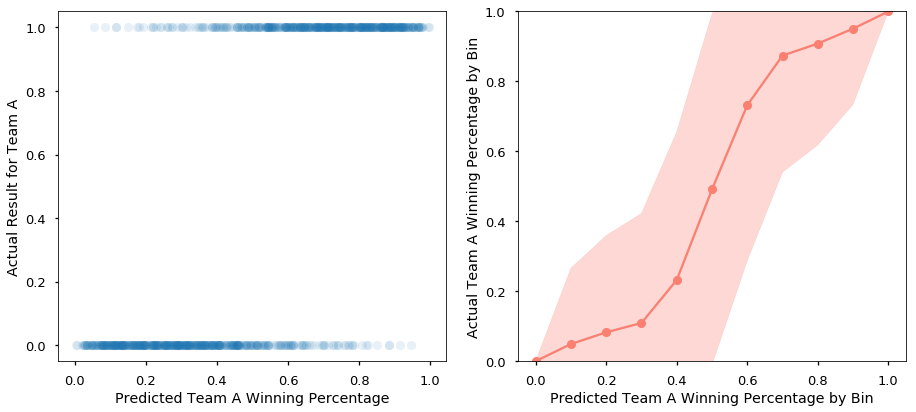

In [31]:
sns.set_context('talk')
f, axes = plt.subplots(1, 2, figsize=(13, 6))
ax = axes[0]
ax.plot(winloss_with_dup['predicted'], winloss_with_dup['Team A Wins'], 'o', alpha=0.1)
ax.set_ylabel('Actual Result for Team A')
ax.set_xlabel('Predicted Team A Winning Percentage')

ax = axes[1]
ax.plot(binned['Team A Wins'], 'o-', color='salmon')
ax.fill_between(binned.index, binnedlo['Team A Wins'], binnedhi['Team A Wins'], alpha=0.3, color='salmon')
ax.set_ylim([0, 1])
ax.set_ylabel('Actual Team A Winning Percentage by Bin')
ax.set_xlabel('Predicted Team A Winning Percentage by Bin')
plt.tight_layout()

In [32]:
team_log_loss = winloss_with_dup.groupby('Team A').apply(
    lambda x: log_loss(x['Team A Wins'].astype('int'), x['predicted'], labels=[0, 1]))

In [33]:
team_accuracy = winloss_with_dup.groupby('Team A').apply(
    lambda x: accuracy_score(x['Team A Wins'].astype('int'), np.round(x['predicted'])))

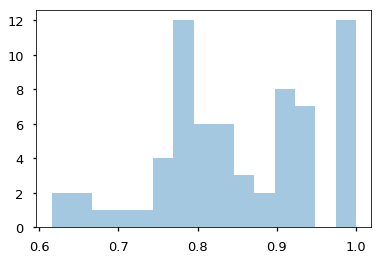

In [34]:
sns.distplot(team_accuracy, kde=False, bins=15)

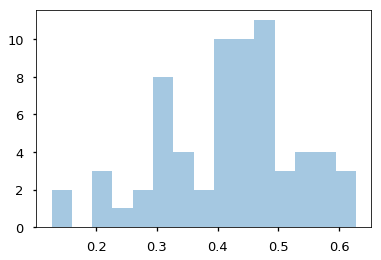

In [35]:
sns.distplot(team_log_loss, kde=False, bins=15)

In [37]:
log_loss(winloss_with_dup['Team A Wins'].astype('int'), winloss_with_dup['predicted'])

0.42382729656670926

In [38]:
accuracy_score(winloss_with_dup['Team A Wins'].astype('int'), np.round(winloss_with_dup['predicted']))

0.84482758620689657

In [39]:
def inspect(full_outcomes, team_name):
    index = full_outcomes['Team A'] == team_name
    outcomes_index = full_outcomes[index]
    return outcomes_index.drop(['divname', 'Index A', 'Index B', 'predBin'], axis=1)

In [40]:
ins = inspect(winloss_with_dup, 'Injustice League')
ins

,Team A,Team B,Team A Wins,Div A,Div B,predicted
180,Injustice League,Turtle Boy,True,4/3 Div 2,4/3 Div 1,0.622337
181,Injustice League,A Lil Bit Sticky,True,4/3 Div 2,4/3 Div 2,0.912463
182,Injustice League,Jack's Abby HAOS Lager,True,4/3 Div 2,4/3 Div 2,0.623212
183,Injustice League,Hipster Kitties,True,4/3 Div 2,4/3 Div 2,0.965832
184,Injustice League,Moose Lightning,True,4/3 Div 2,4/3 Div 2,0.906266
185,Injustice League,Tubbs,True,4/3 Div 2,4/3 Div 2,0.969202
186,Injustice League,Booooooosh!,True,4/3 Div 2,4/3 Div 2,0.886604
187,Injustice League,"Live Poultry, Fresh Killed (LPFK)",True,4/3 Div 2,4/3 Div 1,0.710943
188,Injustice League,Zerg Rush!,False,4/3 Div 2,4/3 Div 1,0.273595
189,Injustice League,Dominion,True,4/3 Div 2,4/3 Div 2,0.858528


In [41]:
ins = inspect(winloss_with_dup, 'Gothrilla')
ins

,Team A,Team B,Team A Wins,Div A,Div B,predicted
14,Gothrilla,AHOC,False,4/3 Div 1,4/3 Div 1,0.245751
15,Gothrilla,Swingers,False,4/3 Div 1,4/3 Div 1,0.739885
16,Gothrilla,FlowChart,True,4/3 Div 1,4/3 Div 1,0.537681
17,Gothrilla,Hucky McThrowandcatch,True,4/3 Div 1,5/2 Div 2,0.918727
18,Gothrilla,SnakeCountryBromance,False,4/3 Div 1,5/2 Div 1,0.350740
19,Gothrilla,Zerg Rush!,False,4/3 Div 1,4/3 Div 1,0.483638
20,Gothrilla,GrassBurner,True,4/3 Div 1,4/3 Div 1,0.702533
21,Gothrilla,Turtle Boy,True,4/3 Div 1,4/3 Div 1,0.810338
22,Gothrilla,"Live Poultry, Fresh Killed (LPFK)",True,4/3 Div 1,4/3 Div 1,0.866007
23,Gothrilla,Upstream,True,4/3 Div 1,4/3 Div 2,0.807113


In [42]:
ins = inspect(winloss_with_dup, 'SnakeCountryBromance')
ins

,Team A,Team B,Team A Wins,Div A,Div B,predicted
666,SnakeCountryBromance,Shake and Bake,True,5/2 Div 1,5/2 Div 1,0.901068
667,SnakeCountryBromance,Zerg Rush!,True,5/2 Div 1,4/3 Div 1,0.634575
668,SnakeCountryBromance,GrassBurner,True,5/2 Div 1,4/3 Div 1,0.808528
669,SnakeCountryBromance,Gothrilla,True,5/2 Div 1,4/3 Div 1,0.649260
670,SnakeCountryBromance,SHRedline,True,5/2 Div 1,5/2 Div 2,0.964925


In [43]:
ins = inspect(winloss_with_dup, 'Store Bought Dirt')
ins

,Team A,Team B,Team A Wins,Div A,Div B,predicted
344,Store Bought Dirt,Upstream,False,4/3 Div 2,4/3 Div 2,0.177924
345,Store Bought Dirt,M.O.B.,True,4/3 Div 2,5/2 Div 3,0.878151
346,Store Bought Dirt,Disc Envy,False,4/3 Div 2,4/3 Div 2,0.483084
347,Store Bought Dirt,Underwater Monkey Cowboys,True,4/3 Div 2,4/3 Div 3,0.807090
348,Store Bought Dirt,Toads,True,4/3 Div 2,4/3 Div 2,0.424291
349,Store Bought Dirt,JHOP,False,4/3 Div 2,4/3 Div 2,0.389224
350,Store Bought Dirt,Nerd Alert,True,4/3 Div 2,4/3 Div 2,0.634531
351,Store Bought Dirt,Dominion,False,4/3 Div 2,4/3 Div 2,0.462300
352,Store Bought Dirt,Fetch,True,4/3 Div 2,4/3 Div 2,0.535141
353,Store Bought Dirt,Flaming Croissants,True,4/3 Div 2,4/3 Div 2,0.348007
